# Project: Text Classification with Various Neural Networks

**Description:** This project covers various neural network architectures 
(CNN, RNN, BERT, BERT w/ CNN/RNN)


## 1. Setup

### 1.1. Libraries and Helper Functions 

In [2]:
#@title Installs

!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 1.8 MB/s 
     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 497.9 MB 3.3 kB/s 
     |████████████████████████████████| 1.4 MB 45.7 MB/s 
     |████████████████████████████████| 5.8 MB 56.9 MB/s 
     |████████████████████████████████| 462 kB 52.9 MB/s 
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.3 MB/s 
     |████████████████████████████████| 182 kB 46.9 MB/s 


In [1]:
#@title Imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim


In [2]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, 
              epochs,
              history1, 
              history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'][:epochs])
    ax1.plot(history1.history['val_loss'][:epochs])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    # ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'][:epochs])
    ax3.plot(history1.history['val_accuracy'][:epochs])
    ax3.set_ylabel('accuracy', bbox=box)
    # ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'][:epochs])
    ax2.plot(history2.history['val_loss'][:epochs])
    # ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)

    # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
    if 'classification_accuracy' in history2.history.keys():
        ax4.plot(history2.history['classification_accuracy'][:epochs])
    else:
        ax4.plot(history2.history['accuracy'][:epochs])
    
    if 'val_classification_accuracy' in history2.history.keys():
        ax4.plot(history2.history['val_classification_accuracy'][:epochs])
    else:
        ax4.plot(history2.history['val_accuracy'][:epochs])
      # ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

In [4]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [5]:
#@title Embedding Matrix Creation

EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

### 1.2 Data Acquisition

In [3]:
train = pd.read_csv('train.tsv', sep='\t')
dev = pd.read_csv('dev.tsv', sep='\t')
df = pd.concat([train, dev])
df.shape

(68221, 2)

In [4]:
train_examples_batch = tf.convert_to_tensor(df['sentence'][:54577])
train_labels_batch = tf.convert_to_tensor(df['label'][:54577])
test_examples_batch = tf.convert_to_tensor(df['sentence'][54577:])
test_labels_batch = tf.convert_to_tensor(df['label'][54577:])

2022-12-03 11:38:55.128596: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
SEQUENCE_LENGTH = 30

## 1.3. Data Preparation

### 1.3.1. Training/Test Sets for Word2Vec-based Models

In [11]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples_batch)
test_tokens = tokenizer.tokenize(test_examples_batch)

In [9]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:SEQUENCE_LENGTH]
        n_padding = (SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        valid_example_list.append(i)
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return (np.array(texts_vocab_ids), valid_example_list)

In [ ]:
train_input_ids, train_valid_example_list = docs_to_vocab_ids(train_tokens)
test_input_ids, test_valid_example_list = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels_batch)
test_input_labels = np.array(test_labels_batch)


Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Total examples:  54576
Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Total examples:  13643


### 1.3.2. Training/Test Sets for BERT-based models

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:

all_train_examples = [x.decode('utf-8') for x in train_examples_batch.numpy()]
all_test_examples = [x.decode('utf-8') for x in test_examples_batch.numpy()]


In [8]:
#@title BERT Tokenization of training and test data

max_length = SEQUENCE_LENGTH


x_train = bert_tokenizer(all_train_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = train_labels_batch

x_test = bert_tokenizer(all_test_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = test_labels_batch

def output_ids(x_data, y_data):

    x_input_ids = []
    y_labels = []

    for ((input_ids, masks), label) in zip(zip(x_data['input_ids'], x_data['attention_mask']), y_data):
        x_input_ids.append(input_ids)
        y_labels.append(label)

    return np.array(x_input_ids), np.array(y_labels) 


In [21]:
bert_train_input_ids, bert_train_labels = output_ids(x_train, y_train)
bert_test_input_ids, bert_test_labels = output_ids(x_test, y_test)

In [ ]:
print(f'The ratio of positive example is {sum(train_input_labels)/len(train_input_labels):.2f} which is a balanced dataset.')
print(f'The ratio of positive example for test set is {sum(test_input_labels)/len(test_input_labels):.2f}.')

The ratio of positive example is 0.56 which is a balanced dataset.
The ratio of positive example for test set is 0.55.


## 2. Experiments

### 2.1 Baseline 1 - Deep Averaging Network

In [ ]:
def create_dan_model(retrain_embeddings=False, 
                     max_sequence_length=SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec', 
                     learning_rate=0.001):
    """
    Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
    :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
    :param hidden_dim: dimension of the hidden layer
    :param dropout: dropout applied to the hidden layer

    :returns: the compiled model
    """

    if embedding_initializer == 'word2vec':
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
    else:
        embeddings_initializer='uniform'

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer = embeddings_initializer,
                                  input_length = max_sequence_length,
                                  trainable = retrain_embeddings)
    dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    if type(hidden_dim) is not list:
        hidden_dim = [hidden_dim]

    for i, h_dim in enumerate(hidden_dim):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu', name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  
    dan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='dan_classification')(last_hidden_output)

    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])

    dan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                       beta_1=0.9,
                                                       beta_2=0.999,
                                                       epsilon=1e-07,
                                                       amsgrad=False,
                                                       name='Adam'),
                    metrics='accuracy')


    return dan_model

In [ ]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

In [ ]:
dan_model_shuffled = create_dan_model()                                                      

dan_suffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                                            sorted_training_labels,
                                            validation_data=(test_input_ids, test_input_labels),
                                            batch_size=32,
                                            epochs=20,
                                            shuffle=True
                                            )                       

Epoch 1/20
1706/1706 [==============================] - 9s 4ms/step - loss: 0.5134 - accuracy: 0.7490 - val_loss: 0.4354 - val_accuracy: 0.8041
Epoch 2/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.4227 - accuracy: 0.8017 - val_loss: 0.4101 - val_accuracy: 0.8064
Epoch 3/20
1706/1706 [==============================] - 5s 3ms/step - loss: 0.4048 - accuracy: 0.8076 - val_loss: 0.3997 - val_accuracy: 0.8122
Epoch 4/20
1706/1706 [==============================] - 5s 3ms/step - loss: 0.3959 - accuracy: 0.8124 - val_loss: 0.3940 - val_accuracy: 0.8138
Epoch 5/20
1706/1706 [==============================] - 5s 3ms/step - loss: 0.3900 - accuracy: 0.8145 - val_loss: 0.3894 - val_accuracy: 0.8150
Epoch 6/20
1706/1706 [==============================] - 7s 4ms/step - loss: 0.3854 - accuracy: 0.8176 - val_loss: 0.3878 - val_accuracy: 0.8183
Epoch 7/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.3816 - accuracy: 0.8199 - val_loss: 0.3859 - val_accuracy:

### 2.2 Baseline - Deep Averaging Models

In [ ]:
dan_model_v1 = create_dan_model(retrain_embeddings=False, max_sequence_length=SEQUENCE_LENGTH, hidden_dim=100, dropout=0.3, embedding_initializer='word2vec', learning_rate=0.001)

dan_model_v2 = create_dan_model(retrain_embeddings=True, max_sequence_length=SEQUENCE_LENGTH, hidden_dim=100, dropout=0.3, embedding_initializer='word2vec', learning_rate=0.001)

dan_model_v3 = create_dan_model(retrain_embeddings=True, max_sequence_length=SEQUENCE_LENGTH, hidden_dim=100, dropout=0.3, embedding_initializer='uniform', learning_rate=0.001)


In [ ]:
dan_history_v1 = dan_model_v1.fit(sorted_training_input_ids, sorted_training_labels, validation_data=(test_input_ids, test_input_labels), batch_size=32, epochs=20)


Epoch 1/20
1706/1706 [==============================] - 6s 3ms/step - loss: 0.5130 - accuracy: 0.7483 - val_loss: 0.4348 - val_accuracy: 0.8045
Epoch 2/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.4225 - accuracy: 0.8026 - val_loss: 0.4107 - val_accuracy: 0.8057
Epoch 3/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.4056 - accuracy: 0.8089 - val_loss: 0.3994 - val_accuracy: 0.8102
Epoch 4/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.3971 - accuracy: 0.8121 - val_loss: 0.3953 - val_accuracy: 0.8136
Epoch 5/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.3902 - accuracy: 0.8155 - val_loss: 0.3913 - val_accuracy: 0.8140
Epoch 6/20
1706/1706 [==============================] - 6s 4ms/step - loss: 0.3856 - accuracy: 0.8179 - val_loss: 0.3903 - val_accuracy: 0.8166
Epoch 7/20
1706/1706 [==============================] - 6s 3ms/step - loss: 0.3821 - accuracy: 0.8194 - val_loss: 0.3851 - val_accuracy:

In [ ]:
dan_history_v2 = dan_model_v2.fit(sorted_training_input_ids, sorted_training_labels, validation_data=(test_input_ids, test_input_labels), batch_size=32, epochs=20)


Epoch 1/20
1706/1706 [==============================] - 24s 14ms/step - loss: 0.2114 - accuracy: 0.9038 - val_loss: 0.3286 - val_accuracy: 0.8734
Epoch 2/20
1706/1706 [==============================] - 18s 11ms/step - loss: 0.1916 - accuracy: 0.9133 - val_loss: 0.3370 - val_accuracy: 0.8740
Epoch 3/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.1807 - accuracy: 0.9169 - val_loss: 0.3762 - val_accuracy: 0.8765
Epoch 4/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.1667 - accuracy: 0.9225 - val_loss: 0.3701 - val_accuracy: 0.8813
Epoch 5/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.1584 - accuracy: 0.9276 - val_loss: 0.3779 - val_accuracy: 0.8824
Epoch 6/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.1498 - accuracy: 0.9291 - val_loss: 0.4182 - val_accuracy: 0.8832
Epoch 7/20
1706/1706 [==============================] - 18s 11ms/step - loss: 0.1434 - accuracy: 0.9347 - val_loss: 0.4179 -

In [ ]:
dan_history_v3 = dan_model_v3.fit(sorted_training_input_ids, sorted_training_labels, validation_data=(test_input_ids, test_input_labels), batch_size=32, epochs=20)


Epoch 1/20
1706/1706 [==============================] - 19s 11ms/step - loss: 0.4213 - accuracy: 0.7920 - val_loss: 0.3254 - val_accuracy: 0.8576
Epoch 2/20
1706/1706 [==============================] - 18s 11ms/step - loss: 0.2725 - accuracy: 0.8809 - val_loss: 0.3144 - val_accuracy: 0.8644
Epoch 3/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.2324 - accuracy: 0.8981 - val_loss: 0.3131 - val_accuracy: 0.8726
Epoch 4/20
1706/1706 [==============================] - 18s 11ms/step - loss: 0.2088 - accuracy: 0.9058 - val_loss: 0.3200 - val_accuracy: 0.8742
Epoch 5/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.1906 - accuracy: 0.9139 - val_loss: 0.3458 - val_accuracy: 0.8761
Epoch 6/20
1706/1706 [==============================] - 18s 11ms/step - loss: 0.1777 - accuracy: 0.9186 - val_loss: 0.3494 - val_accuracy: 0.8753
Epoch 7/20
1706/1706 [==============================] - 18s 10ms/step - loss: 0.1671 - accuracy: 0.9233 - val_loss: 0.3647 -

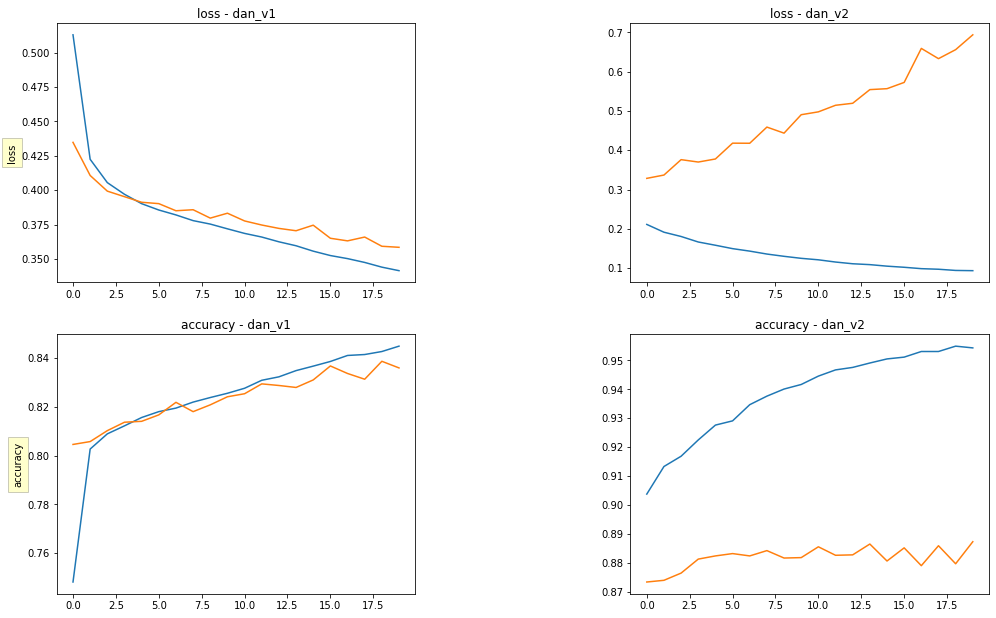

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_history_v1,
          dan_history_v2, 
          model_1_name='dan_v1',
         model_2_name='dan_v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

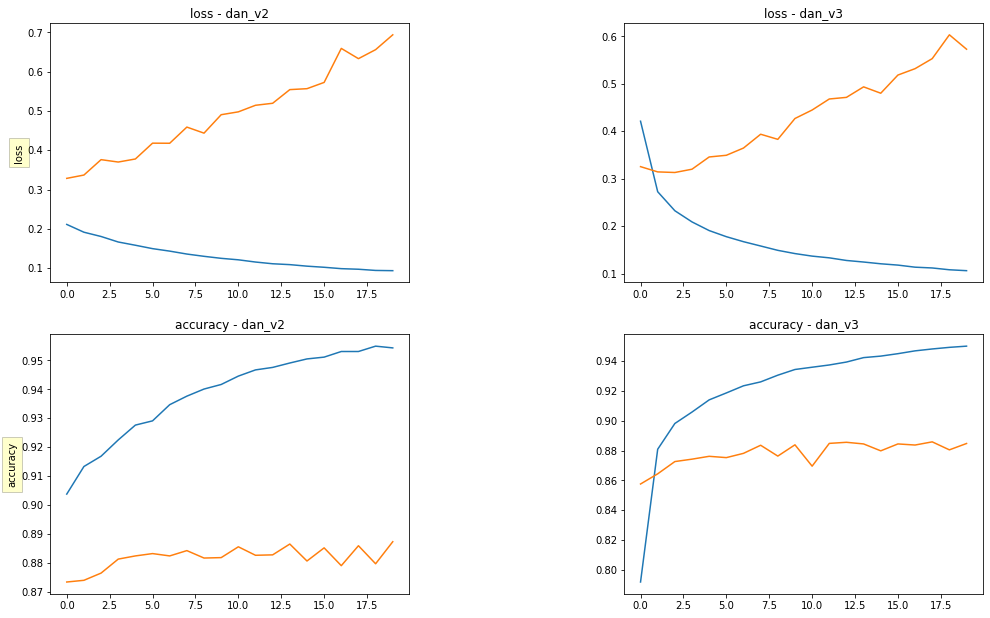

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_history_v2,
          dan_history_v3, 
          model_1_name='dan_v2',
         model_2_name='dan_v3')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 2.3 Experiment 1 - Weighted Averaging Network

In [ ]:
def create_wan_model(retrain_embeddings=False, 
                     max_sequence_length=SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     learning_rate=0.001):
    """
    Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
    :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
    :param hidden_dim: dimension of the hidden layer
    :param dropout: dropout applied to the hidden layer

    :returns: the compiled model
    """
    wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                  input_length = max_sequence_length,
                                  trainable = retrain_embeddings)
    wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')
    wan_embeddings = wan_embedding_layer(wan_input_layer)

    wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
    wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
    wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
    wan_query_vector = wan_query_layer(wan_batch_of_ones)

    wan_attention_output = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings])
    wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)

    last_hidden_output = wan_attention_output

    if type(hidden_dim) is not list:
        hidden_dim = [hidden_dim]

    for i, h_dim in enumerate(hidden_dim):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu', name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  
    wan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='dan_classification')(last_hidden_output)

    wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification])

    wan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                       beta_1=0.9,
                                                       beta_2=0.999,
                                                       epsilon=1e-07,
                                                       amsgrad=False,
                                                       name='Adam'),
                    metrics='accuracy')
    
    return wan_model

In [ ]:
wan_model = create_wan_model()

wan_history = wan_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=20,
                            shuffle=True
                            )


Epoch 1/20
1706/1706 [==============================] - 9s 5ms/step - loss: 0.4418 - accuracy: 0.7848 - val_loss: 0.3886 - val_accuracy: 0.8193
Epoch 2/20
1706/1706 [==============================] - 10s 6ms/step - loss: 0.3826 - accuracy: 0.8198 - val_loss: 0.3726 - val_accuracy: 0.8275
Epoch 3/20
1706/1706 [==============================] - 7s 4ms/step - loss: 0.3703 - accuracy: 0.8244 - val_loss: 0.3672 - val_accuracy: 0.8249
Epoch 4/20
1706/1706 [==============================] - 7s 4ms/step - loss: 0.3613 - accuracy: 0.8311 - val_loss: 0.3626 - val_accuracy: 0.8289
Epoch 5/20
1706/1706 [==============================] - 7s 4ms/step - loss: 0.3552 - accuracy: 0.8339 - val_loss: 0.3617 - val_accuracy: 0.8338
Epoch 6/20
1706/1706 [==============================] - 7s 4ms/step - loss: 0.3494 - accuracy: 0.8367 - val_loss: 0.3540 - val_accuracy: 0.8349
Epoch 7/20
1706/1706 [==============================] - 7s 4ms/step - loss: 0.3423 - accuracy: 0.8417 - val_loss: 0.3498 - val_accuracy

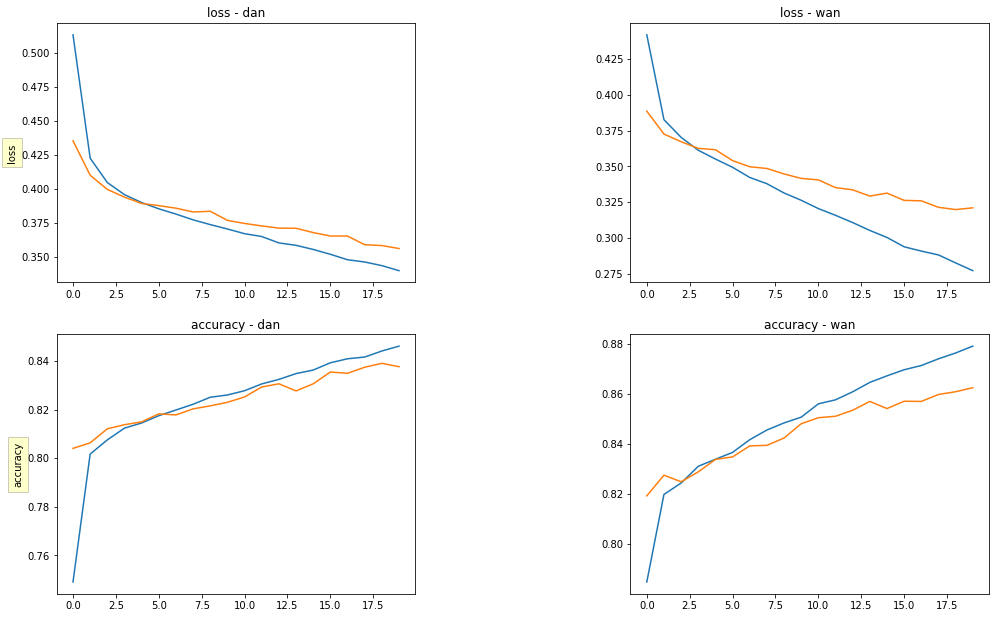

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_suffled_history,
          wan_history, 
          model_1_name='dan',
          model_2_name='wan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 2.4 Experiment 2 - BERT-cased vs BERT-uncased

In [9]:
bert_model_uncased = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
          
        
        # print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                # print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [11]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

x_train_uncased = bert_tokenizer(all_train_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

x_test_uncased = bert_tokenizer(all_test_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [28]:
bert_base_uncased_model = create_bert_classification_model(bert_model_uncased, train_layers=4)
bert_base_uncased_model_history = bert_base_uncased_model.fit(
    [x_train_uncased.input_ids, x_train_uncased.token_type_ids, x_train_uncased.attention_mask],
    y_train,
    validation_data=([x_test_uncased.input_ids, x_test_uncased.token_type_ids, x_test_uncased.attention_mask], y_test),
    batch_size=32,
    epochs=10
) 

Epoch 1/10


1706/1706 [==============================] - 4381s 3s/step - loss: 0.3052 - accuracy: 0.8687 - val_loss: 0.2302 - val_accuracy: 0.9089
Epoch 2/10
1706/1706 [==============================] - 5353s 3s/step - loss: 0.2067 - accuracy: 0.9186 - val_loss: 0.2287 - val_accuracy: 0.9155
Epoch 3/10
1706/1706 [==============================] - 5368s 3s/step - loss: 0.1522 - accuracy: 0.9433 - val_loss: 0.2146 - val_accuracy: 0.9260
Epoch 4/10
1706/1706 [==============================] - 5347s 3s/step - loss: 0.1171 - accuracy: 0.9567 - val_loss: 0.2227 - val_accuracy: 0.9312
Epoch 5/10
1706/1706 [==============================] - 8285s 5s/step - loss: 0.0928 - accuracy: 0.9658 - val_loss: 0.2450 - val_accuracy: 0.9307
Epoch 6/10
1706/1706 [==============================] - 5304s 3s/step - loss: 0.0785 - accuracy: 0.9717 - val_loss: 0.2110 - val_accuracy: 0.9307
Epoch 7/10
1706/1706 [==============================] - 5325s 3s/step - loss: 0.0668 - accuracy: 0.9762 - val_loss: 0.2751 - val_accura

In [ ]:
bert_base_model = create_bert_classification_model(bert_model, train_layers=4)
bert_base_model_history = bert_base_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=10
) 
# eta 0.05, val accuracy 0.7630 (train accuracy 0.7470)

Epoch 1/10


1706/1706 [==============================] - 4658s 3s/step - loss: 0.2910 - accuracy: 0.8758 - val_loss: 0.2069 - val_accuracy: 0.9189
Epoch 2/10
1706/1706 [==============================] - 4924s 3s/step - loss: 0.1960 - accuracy: 0.9233 - val_loss: 0.1980 - val_accuracy: 0.9248
Epoch 3/10
1706/1706 [==============================] - 4519s 3s/step - loss: 0.1457 - accuracy: 0.9446 - val_loss: 0.2120 - val_accuracy: 0.9271
Epoch 4/10
1706/1706 [==============================] - 4538s 3s/step - loss: 0.1143 - accuracy: 0.9567 - val_loss: 0.1978 - val_accuracy: 0.9307
Epoch 5/10
1706/1706 [==============================] - 4572s 3s/step - loss: 0.0901 - accuracy: 0.9662 - val_loss: 0.2271 - val_accuracy: 0.9365
Epoch 6/10
1706/1706 [==============================] - 4982s 3s/step - loss: 0.0763 - accuracy: 0.9719 - val_loss: 0.2270 - val_accuracy: 0.9359
Epoch 7/10
1706/1706 [==============================] - 4902s 3s/step - loss: 0.0663 - accuracy: 0.9754 - val_loss: 0.2655 - val_accura

### 2.5 Experiment 3 - pooled-token vs simple average

In [ ]:
def create_bert_avg_model(bert_model,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')   
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}       

    bert_out = bert_model(bert_inputs)
    
    avg_token = tf.math.reduce_mean(bert_out[0],1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(avg_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    ### END YOUR CODE

    return classification_model

In [ ]:
bert_avg_model = create_bert_avg_model(bert_model)

bert_avg_history = bert_avg_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=10)

### 2.6 Experiment 4 - pooled-token vs CLS-token

In [12]:
def create_bert_cls_model(bert_model,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [13]:
bert_cls_model = create_bert_cls_model(bert_model)

bert_cls_history = bert_cls_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=10)

# eta 0.05, val accuracy 0.8252 (train accuracy 0.6488)

Epoch 1/10


1706/1706 [==============================] - 424s 230ms/step - loss: 0.2352 - accuracy: 0.9082 - val_loss: 0.1915 - val_accuracy: 0.9326
Epoch 2/10
1706/1706 [==============================] - 389s 228ms/step - loss: 0.1258 - accuracy: 0.9560 - val_loss: 0.2070 - val_accuracy: 0.9324
Epoch 3/10
1706/1706 [==============================] - 391s 229ms/step - loss: 0.0885 - accuracy: 0.9699 - val_loss: 0.2115 - val_accuracy: 0.9358
Epoch 4/10
1706/1706 [==============================] - 388s 228ms/step - loss: 0.0692 - accuracy: 0.9760 - val_loss: 0.2835 - val_accuracy: 0.9359
Epoch 5/10
1706/1706 [==============================] - 388s 228ms/step - loss: 0.0535 - accuracy: 0.9815 - val_loss: 0.3067 - val_accuracy: 0.9351
Epoch 6/10
1706/1706 [==============================] - 389s 228ms/step - loss: 0.0467 - accuracy: 0.9838 - val_loss: 0.3553 - val_accuracy: 0.9341
Epoch 7/10
1706/1706 [==============================] - 387s 227ms/step - loss: 0.0410 - accuracy: 0.9855 - val_loss: 0.283

### 2.7 Experiment 5 - BERT-CNN vs BERT-LSTM

In [13]:
def create_bert_cnn_model(bert_model,
                          hidden_size = 100, 
                          learning_rate=0.00005,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [3, 5, 10, 20],
                          dropout = 0.3):
    """
    Build a  classification model with BERT, where you apply CNN layers to the BERT output
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')   
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}       

    bert_out = bert_model(bert_inputs)[0]

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_out)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout)(conv_output)

    last_hidden_output = keras.layers.Dense(hidden_size, activation='relu')(last_hidden_output)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(last_hidden_output)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [16]:
callback = tf.keras.callbacks.EarlyStopping(patience=3)

bert_cnn_model = create_bert_cnn_model(bert_model)

bert_cnn_history = bert_cnn_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=10,
    callbacks=[callback])

Epoch 1/10
1706/1706 [==============================] - 7824s 5s/step - loss: 0.0454 - accuracy: 0.9850 - val_loss: 0.3537 - val_accuracy: 0.9301
Epoch 2/10
1706/1706 [==============================] - 7700s 5s/step - loss: 0.0400 - accuracy: 0.9863 - val_loss: 0.2936 - val_accuracy: 0.9317
Epoch 3/10
1706/1706 [==============================] - 7693s 5s/step - loss: 0.0358 - accuracy: 0.9877 - val_loss: 0.3281 - val_accuracy: 0.9340
Epoch 4/10
1706/1706 [==============================] - 7694s 5s/step - loss: 0.0305 - accuracy: 0.9892 - val_loss: 0.2551 - val_accuracy: 0.9331
Epoch 5/10
1706/1706 [==============================] - 7717s 5s/step - loss: 0.0322 - accuracy: 0.9891 - val_loss: 0.3140 - val_accuracy: 0.9312
Epoch 6/10
1706/1706 [==============================] - 7729s 5s/step - loss: 0.0292 - accuracy: 0.9900 - val_loss: 0.3236 - val_accuracy: 0.9324
Epoch 7/10
1706/1706 [==============================] - 26721s 16s/step - loss: 0.0271 - accuracy: 0.9906 - val_loss: 0.4453

In [11]:
def build_rnn_model(rnn_dim, dense_layer_dims, learning_rate, dropout_rate):
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')   
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}       

    bert_out = bert_model(bert_inputs)[0]

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (bert_out)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[rnn_prediction])
    rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

In [18]:
callback = tf.keras.callbacks.EarlyStopping(patience=3)

rnn_model = build_rnn_model(rnn_dim=100,
                            dense_layer_dims=[100, 100, 50, 25],
                            learning_rate=0.00005,
                            dropout_rate=0.5)

rnn_history = rnn_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                            y_train,
                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
                            batch_size=32,
                            epochs=10,
                            callbacks=[callback]
                            )

Epoch 1/10
1706/1706 [==============================] - 8045s 5s/step - loss: 0.2485 - accuracy: 0.8797 - val_loss: 0.5158 - val_accuracy: 0.9259
Epoch 2/10
1706/1706 [==============================] - 7928s 5s/step - loss: 0.0688 - accuracy: 0.9787 - val_loss: 0.6272 - val_accuracy: 0.9236
Epoch 3/10
1706/1706 [==============================] - 23296s 14s/step - loss: 0.0556 - accuracy: 0.9840 - val_loss: 0.4228 - val_accuracy: 0.9298
Epoch 4/10
1706/1706 [==============================] - 12418s 7s/step - loss: 0.0532 - accuracy: 0.9854 - val_loss: 0.7920 - val_accuracy: 0.9293
Epoch 5/10
1706/1706 [==============================] - 35509s 21s/step - loss: 0.0475 - accuracy: 0.9872 - val_loss: 0.7256 - val_accuracy: 0.9277
Epoch 6/10
1706/1706 [==============================] - 10061s 6s/step - loss: 0.0440 - accuracy: 0.9879 - val_loss: 0.6599 - val_accuracy: 0.9256


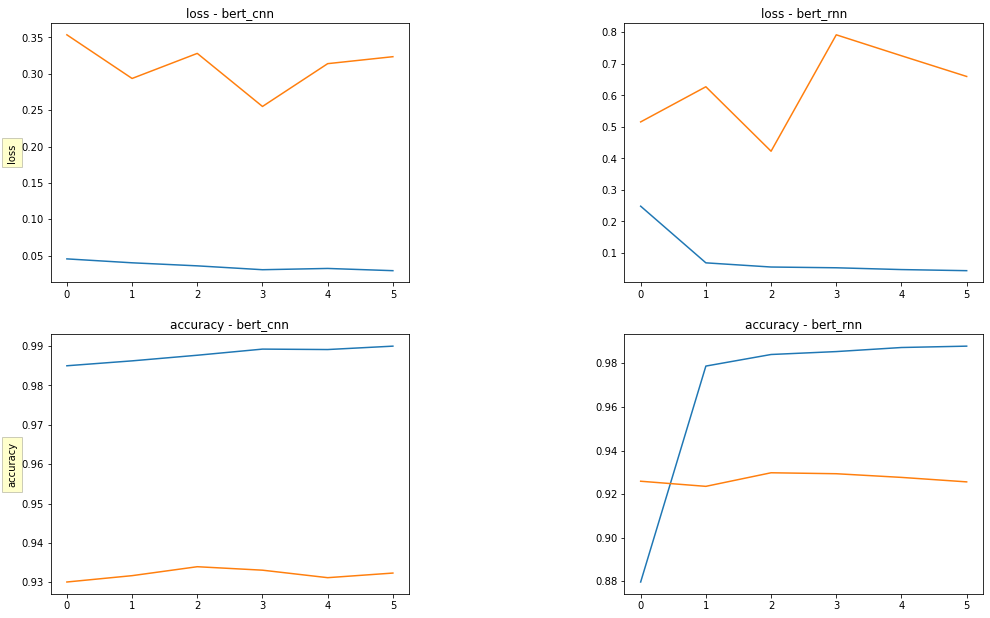

In [22]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 6,
          bert_cnn_history,
          rnn_history, 
          model_1_name='bert_cnn',
          model_2_name='bert_rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()